# Hyperparameter analysis

This notebook attempts to analyze most common combinations of optimal hyperparameters to improve model tuning in the future (and reduce generation time).

In [19]:
# %load ../src/genetic.py
"""
1st script in the pipeline, generating the largest dataset.
Fast, parallelizable genetic algorithm implementation with some extensions.

Numpy array naming convention:
- *_ids = array of number corresponding to rows in the dataset
- *_index = boolean array allowing for fast selection from the dataset
"""

import pandas as pd
import numpy as np
np.random.seed(420)

from sklearn.svm import SVR
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import r2_score

from tqdm import trange
from numba import jit
import click

import multiprocessing as mp
import pickle
from itertools import repeat
from pathlib import Path
from datetime import datetime
from typing import NamedTuple, List, Tuple


class DataSet(NamedTuple):
    X: np.array  # (n_samples, n_features)
    y: np.array  # 1d
    ids: np.array  # 1d


class GenerationParams(NamedTuple):
    n_models: int
    train_ids: np.array  # (n_models, n_train_samples)
    n_fits: int  # per each model during hyperparameter optimization
    train_data: DataSet
    n_train_samples: int
    train_probs: np.array
    valid_data: DataSet
    valid_index: np.array
    mutation_prob: float
    score_mode: str
    weights: np.array

class FitParams(NamedTuple):
    train_index: np.array # 1d train_size
    n_fits: int
    train_data: DataSet
    valid_data: DataSet
    valid_index: np.array


class FitResult(NamedTuple):
    train_index: np.array
    model_pred: np.array
    model_score: float
    model_params: dict


class MutationParams(NamedTuple):
    pair: np.array
    train_probs: np.array
    mutation_prob: float


class GenerationResult(NamedTuple):
    train_probs: np.array
    # train_index: np.array  # (n_samples), True for samples that were used in any of the models
    model_scores: np.array
    model_params: List[dict]
    model_samples: np.array  # (n_models, n_train_samples) - IDs, NOT INDEX


class EvolutionParams(NamedTuple):
    n_models: int  # = datasets per generation
    n_fits: int  # per each model during hyperparameter optimization
    n_generations: int
    n_train_samples: int
    n_valid_samples: int
    train_ids: np.array
    mutation_prob: float  # between 0 and 1
    score_mode: str
    weights: np.array
    validation_mode: str


# defaults for random hyperparameter search
params_dict = {
    'kernel': ['rbf'],
    'gamma': [1.0 / 90],
    'C': [1.0],
    'epsilon': [0.02],
    'shrinking': [False]
}


def sample(n_samples: int, ids: np.array, weights: np.array=None) -> np.array:
    selected_ids = np.random.choice(ids, n_samples, replace=False, p=weights)
    selected_index = np.isin(ids, selected_ids, assume_unique=True)
    return selected_index  # same shape as ids, for easier selection


def fit_svr(
        X_train: np.array,
        y_train: np.array,
        X_valid: np.array,
        y_valid: np.array,
        params_dict: dict=params_dict,
        n_iter: int=25
):
    ps = ParameterSampler(n_iter=n_iter, param_distributions=params_dict)
    scores = np.zeros(n_iter)
    models = list(repeat(None, n_iter))
    for idx, params in enumerate(ps):
        svr = SVR(**params)
        svr.fit(X_train, y_train)
        scores[idx] = r2_score(y_valid, svr.predict(X_valid))
        models[idx] = svr
    return models[np.argmax(scores)]


def fit_thread(params: GenerationParams) -> FitResult:
    model = fit_svr(
        params.train_data.X[params.train_index],
        params.train_data.y[params.train_index],
        params.valid_data.X[params.valid_index],
        params.valid_data.y[params.valid_index],
        n_iter=params.n_fits
    )
    model_pred = model.predict(params.train_data.X)
    model_score = r2_score(
        params.valid_data.y[params.valid_index],
        model.predict(params.valid_data.X[params.valid_index])
    )
    return FitResult(params.train_index, model_pred, model_score, model.get_params())


def crossover_thread(params: MutationParams):
    intersection = np.intersect1d(params.pair[0], params.pair[1])
    rest = np.setxor1d(params.pair[0], params.pair[1])
    if len(rest) == 0:
        new_ids = intersection
    else:
        other = np.random.choice(
            rest, len(params.pair[0]) - len(intersection), replace=False,
        )
        new_ids = np.concatenate([intersection, other])
    assert len(new_ids) == len(params.pair[0])
    # Mutation
    np.random.shuffle(new_ids)
    survival_boundary = round(len(new_ids) * params.mutation_prob)
    chosen = new_ids[:-survival_boundary]
    params.train_probs[chosen.astype(np.int)] = 0
    assert params.train_probs[chosen.astype(np.int)].sum() == 0
    adjusted_params = params.train_probs / params.train_probs.sum()
    assert adjusted_params[chosen.astype(np.int)].sum() == 0
    supplied = np.random.choice(
        np.arange(len(params.train_probs)),
        size=survival_boundary,
        replace=False,
        p=adjusted_params
    )
    result = np.concatenate([chosen, supplied])
    assert len(result) == params.pair.shape[1]
    return result.astype(np.int)


def select_best(model_scores):
    normalized_scores = model_scores / np.sum(model_scores)
    sorted_order = np.argsort(-normalized_scores)  # sort by DESCENDING SCORE
    cum_scores = np.cumsum(normalized_scores[sorted_order])
    fitness_threshold = (np.random.random() / cum_scores[1]) + cum_scores[1]
    fit_scores = cum_scores < fitness_threshold
    return sorted_order[fit_scores]


def calculate_probs(models_pred: np.array, mode: str, y: np.array=None, weights=None):
    if mode == "weights":
        return weights

    elif mode == "leave-std-variance":
        train_var = models_pred.var(axis=0)
        scores = train_var

        # zeroout some probs
        mean_score = scores.mean()
        std_score = scores.std()
        scores[np.abs(scores - mean_score) > std_score * 0.7] = 0

        exploded_scores = np.exp(scores)
        normalized_scores = exploded_scores / exploded_scores.sum()
        return normalized_scores

    elif mode == "weighted-variance":
        train_var = models_pred.var(axis=0)
        scores = train_var

        exploded_scores = np.exp(scores) * weights

        # zeroout prob of half of the samples that were predicted correctly
        sorted_order_ids = np.argsort(exploded_scores)  # sort by ASCENDING SCORE
        cum_scores = np.cumsum(exploded_scores[sorted_order_ids])
        unfit_index = (cum_scores / cum_scores[-1]) < 0.5  # eliminate most accurately predicted samples
        exploded_scores[sorted_order_ids[unfit_index]] = 0

        normalized_scores = exploded_scores / exploded_scores.sum()
        return normalized_scores

    elif mode == "variance":
        train_var = models_pred.var(axis=0)
        assert len(train_var) == models_pred.shape[1]
        scores = train_var

    elif mode == "loss":
        if y is None:
            raise AttributeError(f"y can't be None when using 'loss' mode")
        loss = np.subtract(models_pred, y.reshape(1, -1)) ** 2
        scores = loss.mean(axis=0)
    else:
        raise AttributeError(f"No such method: {mode}")

    exploded_scores = np.exp(scores)

    # zeroout prob of half of the samples that were predicted correctly
    sorted_order_ids = np.argsort(exploded_scores)  # sort by ASCENDING SCORE
    cum_scores = np.cumsum(exploded_scores[sorted_order_ids])
    unfit_index = (cum_scores / cum_scores[-1]) < 0.9  # eliminate most accurately predicted samples
    exploded_scores[sorted_order_ids[unfit_index]] = 0

    normalized_scores = exploded_scores / exploded_scores.sum()
    return normalized_scores


def run_generation(params: GenerationParams, pool: mp.Pool) -> (GenerationParams, GenerationResult):
    models_pred = np.zeros((params.n_models, len(params.train_probs)))
    model_params = list(repeat({}, params.n_models))
    model_scores = np.zeros(params.n_models)
    model_samples = np.zeros((params.n_models, params.n_train_samples))

    fit_params = [FitParams(
        train_index=params.train_ids[i],
        n_fits=params.n_fits,
        train_data=params.train_data,
        valid_data=params.valid_data,
        valid_index=params.valid_index,
    ) for i in range(len(params.train_ids))]

    results = pool.map(fit_thread, fit_params)
    for idx, fit_result in enumerate(results):
        models_pred[idx] = fit_result.model_pred
        model_params[idx] = fit_result.model_params
        model_scores[idx] = fit_result.model_score
        model_samples[idx] = params.train_data.ids[fit_result.train_index].astype(np.uint)

    chosen_samples = model_samples[select_best(model_scores)]
    comb = np.random.randint(low=0, high=len(chosen_samples), size=(params.n_models, 2))
    pairs = [chosen_samples[c] for c in comb]
    train_probs = calculate_probs(models_pred, mode=params.score_mode, y=params.train_data.y, weights=params.weights)
    crossover_param_list = [MutationParams(pair=p, train_probs=train_probs, mutation_prob=params.mutation_prob) for p in pairs]
    new_ids = pool.map(crossover_thread, crossover_param_list)

    new_params = params._replace(train_ids=np.asarray(new_ids), train_probs=train_probs)
    return new_params, GenerationResult(train_probs, model_scores, model_params, model_samples)


def resample_validation(train_data:DataSet, valid_data: DataSet, train_for_validation_ids: np.array, n_valid_samples: int):
    chosen_index = sample(len(valid_data.y), train_for_validation_ids)
    chosen_ids = train_for_validation_ids[chosen_index]

    new_valid = DataSet(
        X=np.concatenate([valid_data.X, train_data.X[chosen_ids]]),
        y=np.concatenate([valid_data.y, train_data.y[chosen_ids]]),
        ids=np.arange(len(valid_data.y) + len(chosen_ids))
    )
    valid_index = sample(n_valid_samples, new_valid.ids)
    return new_valid, valid_index


def run_evolution(train_data: DataSet, valid_data: DataSet, pool: mp.Pool, params: EvolutionParams):
    if params.validation_mode == "original":
        valid_index = sample(params.n_valid_samples, valid_data.ids)
    elif params.validation_mode == "upsampling":
        train_for_validation_ids = train_data.ids[params.weights > params.weights.mean()]
    else:
        raise AttributeError(f"Validation mode {params.validation_mode} does not exists")

    train_probs = np.ones(len(train_data.ids)) / len(train_data.ids)
    results = []
    if params.train_ids is None:
        train_ids = np.random.choice(
            train_data.ids,
            size=(params.n_models, params.n_train_samples),
            replace=False,
        )
    else:
        train_ids = params.train_ids

    new_valid_data, valid_index = resample_validation(train_data, valid_data, train_for_validation_ids, params.n_valid_samples)
    next_gen_params = GenerationParams(
        n_models=params.n_models,
        n_fits=params.n_fits,
        train_data=train_data,
        n_train_samples=params.n_train_samples,
        train_probs=train_probs,
        valid_data=new_valid_data,
        valid_index=valid_index,
        mutation_prob=params.mutation_prob,
        train_ids=train_ids,
        score_mode=params.score_mode,
        weights=params.weights,
    )

    with trange(params.n_generations) as t:
        for generation_idx in t:
            try:
                t.set_description(f"Generation {generation_idx+1}")
                if params.validation_mode == "upsampling":
                    new_valid_data, valid_index = resample_validation(train_data, valid_data, train_for_validation_ids, params.n_valid_samples)
                    next_gen_params._replace(valid_data=new_valid_data, valid_index=valid_index)
                next_gen_params, gen_results = run_generation(next_gen_params, pool)
                results.append(gen_results)
                t.set_postfix(
                    mean_score=sum(gen_results.model_scores)/len(gen_results.model_scores),
                    max_score=max(gen_results.model_scores)
                )
            except KeyboardInterrupt:
                print("KeyboardInterrupt: stopping evolution...")
                break
    return results


@click.command()
@click.option("-n", "--n-threads", default=4)
@click.option("-i", "--input-dir", type=str, default='../data')
@click.option("-o", "--output-path", type=str,
              default=datetime.now().strftime('../data/genetic-%d-%m-%y-%H-%M-%S.pkl'))
def main(n_threads, input_dir, output_path):
    input_dir = Path(input_dir).resolve()
    output_path = Path(output_path).resolve()
    train_X = np.load(input_dir / 'train_X.npy')
    train_y = np.load(input_dir / 'train_y.npy')
    valid_X = np.load(input_dir / 'reduced_valid_X.npy')
    valid_y = np.load(input_dir / 'reduced_valid_y.npy')
    train_data = DataSet(train_X, train_y, np.arange(len(train_X)))
    valid_data = DataSet(valid_X, valid_y, np.arange(len(valid_X)) * (-1))

    weights = np.load(input_dir / 'train_nofGames.npy')
    weights[weights < weights.mean()] = 0
    weights = weights / weights.sum()

    params = EvolutionParams(
        n_models = 4,
        n_fits = 1,
        n_generations = 128,
        n_train_samples = 1000,
        n_valid_samples = 8000,
        train_ids = None,
        mutation_prob = 0.04,
        score_mode = "weights",
        weights = weights,
        validation_mode="upsampling",
    )
    with mp.Pool(n_threads) as pool:
        results = run_evolution(train_data, valid_data, pool, params)
        print(f"Saving results to {output_path}...")
        pickle.dump(results, open(output_path, 'wb'))
        print("Done")


if __name__ == '__main__':
    main()


In [20]:
import pickle

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [22]:
results = pickle.load(open('../data/genetic-08-06-19-23-38-49.pkl', 'rb'))

In [23]:
def result_to_df(result: GenerationResult, generation: int) -> pd.DataFrame:
    dfs = []
    for idx in range(len(result.model_scores)):
        score = result.model_scores[idx]
        params = result.model_params[idx]
        dfs.append(pd.DataFrame(
            {
                'generation': generation,
                'score': score,
                **params,
            },
            index=[idx]
        ))
    return pd.concat(dfs, axis='index', ignore_index=True)

In [24]:
model_df = pd.concat([
    result_to_df(res, gen_idx)
    for gen_idx, res
    in tqdm(enumerate(results), total=len(results))
], axis='index', ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 399/399 [01:34<00:00,  3.70it/s]


In [25]:
model_df = model_df.sort_values(by=['score', 'generation'], ascending=False)

Number of generations with good enough score: 53


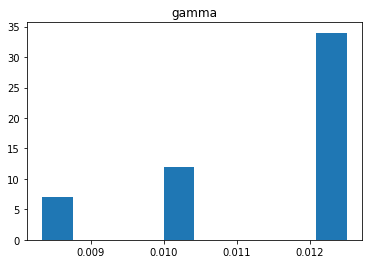

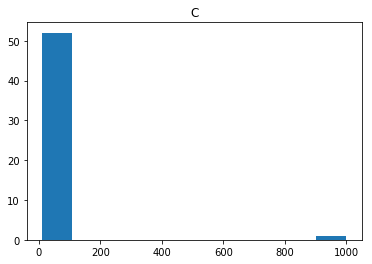

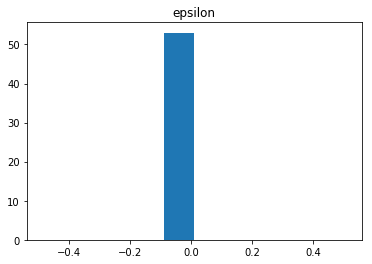

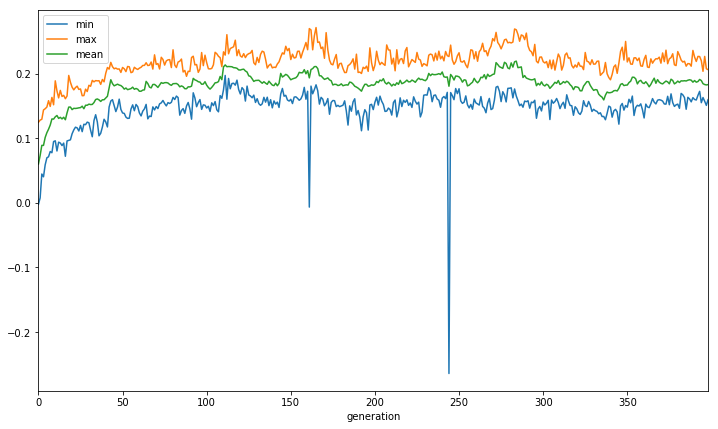

In [26]:
TUNABLE_PARAMS = ['gamma', 'C', 'epsilon']
SCORE_THRESHOLD = 0.9 * model_df['score'].max()

params_df = model_df[model_df['score'] > SCORE_THRESHOLD][TUNABLE_PARAMS]
print(f"Number of generations with good enough score: {len(params_df)}")
for col in params_df.columns:
    plt.hist(params_df[col])
    plt.title(col)
    plt.show()
    
model_df.sort_values(by='generation').groupby('generation').score.agg(['min', 'max', 'mean']).plot(figsize=(12, 7))
plt.show()